In [3]:
%matplotlib inline
from __future__ import division
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import djPyi2 as DJ
from djPyi2 import Common as CM
from djPyi2 import mpltools

import pandas as pd
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import itertools
import tempfile
import six
import networkx as nx
import scipy.stats as stats
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import datetime

from scipy.stats import mode
dy_name = 'hipstr_qc_analysis'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    cpy.makedir(private_out)

/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [26]:
def add_percentage_of_sites(fdf, cat, lab):
    fdf = fdf.copy()
    fdf = fdf.reset_index()
    dict_maxes = {}
#     fdf['PERC_SITES'] = 0
    dfs = []
    for i,df in fdf.groupby(cat):
        m = df[lab].max()
        inds = df.index.tolist()
        dict_maxes[i] = m
        
        Frac_Max = (df[lab] / m)
        dfs.append(Frac_Max)
    
    t = pd.concat(dfs)
    fdf['PERC_SITES'] = t
    
    return fdf
    

def filtering_df(rr_df, info, cat, subcat_col, thresholds, subcat = False, reverse = False):
    
    def add_num_sites_total(df, info, thresholds, cat, subcat_col=False, subcat=False, reverse = False):
        data = []
        for i in thresholds:
            if not reverse:
                
                if subcat:
                    s =  info[(info[cat] >= i) & (info[subcat_col] == subcat)].shape[0]
                else:
                    s = info[info[cat] >= i].shape[0]
            
            else:
                if subcat:
                    s =  info[(info[cat] < i) & (info[subcat_col] == subcat)].shape[0]
                else:
                    s = info[info[cat] < i].shape[0]
            data.append(s)
        df = df.copy()
        df['num_sites_all'] = data
        return df
    
   
    dfs = []
    
    for g, df in rr_df.groupby(subcat_col):
        data = []
        for thresh in thresholds:
            if reverse:
                tdf = df[(df[cat] < thresh)]
            else:
                tdf = df[(df[cat] >= thresh)]
            m = tdf.RR.astype(float).mean()
            s = tdf.shape[0]
            data.append([thresh, s, m, g])
    
    
            
        filtDf = pd.DataFrame(data, columns=['thresh', 'num_sites', 'mean_replication_rate', 'PERIOD'])
        filtDf = filtDf.pipe(add_num_sites_total, info, thresholds, cat, subcat_col=subcat_col, subcat=g, reverse=reverse)
        dfs.append(filtDf)
    
    # with no subtypes
    data = []
    for thresh in thresholds:
        if reverse:
            tdf = rr_df[(rr_df[cat] < thresh)]
        else:
            tdf = rr_df[(rr_df[cat] >= thresh)]
        m = tdf.RR.astype(float).mean()
        s = tdf.shape[0]
        data.append([thresh, s, m, 'all'])
    filtDf = pd.DataFrame(data, columns=['thresh', 'num_sites', 'mean_replication_rate', 'PERIOD'])
    filtDf = filtDf.pipe(add_num_sites_total, info, thresholds, cat, subcat=False, reverse = reverse)
    filtDf = filtDf.pipe(add_percentage_of_sites, 'PERIOD', 'num_sites_all')
    
    dfs.append(filtDf)
    df_out = pd.concat(dfs)
    
    df_out = df_out.pipe(add_percentage_of_sites, 'PERIOD', 'num_sites_all')
    
    return df_out 

In [24]:
def plot_discordance_vs_cat(df,labels, colors, thresholds, num_sites, cat, letter_label = False, ax = False):
    min_thresh = min(thresholds)
    max_thresh = max(thresholds)
    
    
    with sns.axes_style('ticks'):
        if ax:
            ax = ax
        else:
            fig, ax = plt.subplots(1,1, figsize = (8,5))
        
        # color bar plotting
        divider = make_axes_locatable(ax)
        axDivY = divider.append_axes( 'right', size=0.2, pad= 0.1)
        cmap = plt.cm.PuBu
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_thresh, vmax=max_thresh))
        sm.set_array([]) 
        cbar = plt.colorbar(sm, cax = axDivY)
        cbar.set_ticks(thresholds)
        
        patches = mpltools.get_legend_patches(labels, markeredgecolor=colors,
                                     markerfacecolor='white', markeredgewidth=2, markersize=10)
        
        axDivY.set_ylabel(cat)
        axDivY.yaxis.set_label_position("right")
        
        for c, l in zip(colors, labels):
            tdf = df[df.PERIOD == l]
            tdf = tdf.sort_values('thresh')
         
            ax.scatter(tdf[num_sites], tdf.mean_replication_rate, c = tdf.thresh, cmap= cmap, lw = 1, edgecolor = c, label = l, zorder = 10)
            ax.plot(tdf[num_sites], tdf.mean_replication_rate, c = c, lw = 1, zorder = 2)
        
        
        leg = ax.legend(handles = patches, bbox_to_anchor = [0,1],loc = 'lower left',ncol = 6, frameon=True, handletextpad=0.5, handlelength = 0.8)
#         leg = ax.legend(handles = patches, bbox_to_anchor = (1,0), loc='lower right',ncol = 1,
#                              fontsize= 11, title = 'PERIOD', frameon=True, borderaxespad=0)
        leg.get_frame().set_facecolor('white')
        leg.get_frame().set_edgecolor('black')
        plt.setp(leg.get_title(), fontsize=12, color='Black')
        
        ax.set(ylabel = 'Mean Replication Rate', xlabel = 'Fraction Total Sites')      
#         fig.text(0.98, 0.5, "{} threshold".format(cat), rotation= 90, horizontalalignment='center', verticalalignment='center', fontsize = 15)
        
        
        
        ax.axhline(0.9, 0,1, linestyle = '--', )
        
#         fig.text(0.05, 0.95, "{}".format(letter_label), horizontalalignment='center', verticalalignment='center', fontsize = 18, fontweight='bold')
        return ax, axDivY, leg

In [6]:
def lambda_num_alleles(x):
    spl = x.split(',')
    allele_dict = {i.split(":")[0]: i.split(':')[1] for i in spl}
    
    alleles  = [i for i in allele_dict.keys() if i != './.']
    num_alleles = len(alleles)
    alleles_dist_non_missing = [":".join([i,k]) for i, k in allele_dict.iteritems() if i != './.']
    return num_alleles, ",".join(alleles), ",".join(alleles_dist_non_missing)

In [7]:
def prep_info(df):
    df = df.copy()
    t = df.ALLELES_DIST.apply(lambda x: lambda_num_alleles(x))
    tdf = pd.DataFrame(list(t))
    tdf.columns = ['NUM_ALLELES', 'ALLELES', 'ALLELES_DIST_MOD']
    df = df.join(tdf)
    return df

In [8]:
def modify_per_sample(df, sample_info):
    
    df = df.copy()
    df['sample'] = df.index
#     df.index = df['sample']
    cols = ['CELL_TYPE', 'STUDY','SEX', 'GENETICALLY_SIMILAR_POPULATION_GROUP']
    def mod_ethnicity(x):
        if x == 'AFR':
            return 'African'
        else:
            return 'Non African'
        
    df = df.join(sample_info[cols])
    df['ethnicity_mod'] = df['GENETICALLY_SIMILAR_POPULATION_GROUP'].apply(lambda x: mod_ethnicity(x))
    
    df = df.sort_values(['STUDY', 'CELL_TYPE', 'ethnicity_mod', 'SEX','sample'])
    df['x'] = range(df.shape[0])
    return df

In [9]:
sample_info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/sample_info_combined/sample_info.pkl')



In [77]:
fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_hipsci_ref_filt_geno/hipstr_per_sample_length.tsv'
rr_length_per_sample = pd.read_table(fn, index_col=0)

In [78]:
rr_length_per_sample = rr_length_per_sample.pipe(modify_per_sample, sample_info)

# Distributions of Calls/Missing per Sample

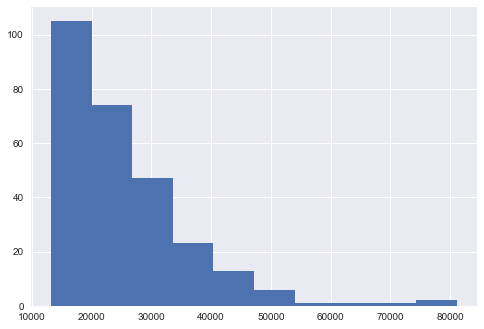

In [79]:
rr_length_per_sample.MISSING.hist()

In [81]:
cell_type_color_dict = {'Blood': '#efe4bf', 'Fibroblast': '#dce8b2', 'iPSC':'#c2d6c8'}
ethnicity_color_dict = {'African': '#baced8', 'Non African': '#6b818c'}
rr_length_per_sample['color_fill'] = rr_length_per_sample.ethnicity_mod.apply(lambda x: ethnicity_color_dict[x])
rr_length_per_sample['color_edge'] = rr_length_per_sample.CELL_TYPE.apply(lambda x: cell_type_color_dict[x])


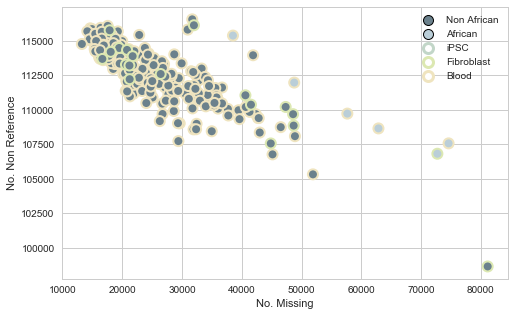

In [82]:
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(1,1, figsize = (8,5))
    ax.scatter(rr_length_per_sample.MISSING, rr_length_per_sample.NREF, edgecolors=rr_length_per_sample.color_edge, c= rr_length_per_sample.color_fill, s=100, lw = 2)
    labels = ethnicity_color_dict.keys()
    colors = ethnicity_color_dict.values()
    patches = mpltools.get_legend_patches(labels, markerfacecolor=colors, markersize = 10)
    
    labels2 = cell_type_color_dict.keys()
    colors2 = cell_type_color_dict.values()
    patches_2 = mpltools.get_legend_patches(labels2, markerfacecolor='white', markeredgecolor=colors2, markersize=10, markeredgewidth=3)
    
    patches_all = patches + patches_2

    ax.legend(handles = patches_all)
    plt.xlabel('No. Missing')
    plt.ylabel('No. Non Reference')

In [86]:
rr_length_per_sample[rr_length_per_sample.MISSING > 75000]

,MISSING,NREF,REF,sample,CELL_TYPE,STUDY,SEX,GENETICALLY_SIMILAR_POPULATION_GROUP,ethnicity_mod,x,color_fill,color_edge
c45b714b-c3a6-4a37-87d4-1cb9ba079706,81129,98665,647848,c45b714b-c3a6-4a37-87d4-1cb9ba079706,Fibroblast,iPSCORE,M,EUR,Non African,269,#6b818c,#dce8b2


In [63]:
ipscore_info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ipscore_sample_info/ipscore_info.pkl')


In [61]:
ind = rr_length_per_sample[rr_length_per_sample.NREF > 120000].index.tolist()

Text(0,0.5,u'No. Samples')

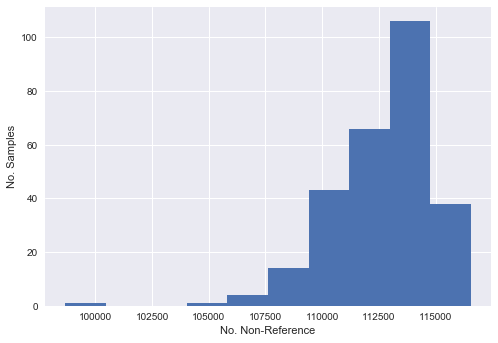

In [83]:
rr_length_per_sample.NREF.hist()
plt.xlabel('No. Non-Reference')
plt.ylabel('No. Samples')

# Input Data

In [10]:
fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_hipsci_ref_filt_geno2/hipstr_per_pair_length.tsv'
rr_length_per_pair = pd.read_table(fn)

fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_hipsci_ref_filt_geno2/hipstr_per_pair_gt.tsv'
rr_gt_per_pair = pd.read_table(fn)


fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_hipsci_ref_filt_geno2/hipstr_replication_length_info.tsv'
rr_info_length = pd.read_table(fn)

# fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_filt_geno/hipstr_replication_gt_info.tsv'
# rr_info_gt = pd.read_table(fn)

In [11]:
fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_hipsci_ref_filt_geno2/hipstr_info_dosage.tsv'

info_dosage = pd.read_table(fn).pipe(prep_info)

In [12]:
info_dosage.shape

(827230, 28)

In [14]:
1516926-726694

790232

In [15]:
info_dosage['INFRAME_P_Max'] = info_dosage[['INFRAME_UP', 'INFRAME_DOWN']].max(axis = 1)

In [16]:
rr_info_length['INFRAME_P_Max'] = rr_info_length[['INFRAME_UP', 'INFRAME_DOWN']].max(axis = 1)

# Per Twin Pair RR Percentage

In [17]:
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14

In [9]:
twin_fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ipscore_sample_info/twins.tsv'
pairs = [line.rstrip().split() for line in open(twin_fn)]   

In [10]:
rr_length_per_pair['Pair'] = ["_".join(p) for p in pairs]
rr_gt_per_pair['Pair'] = ["_".join(p) for p in pairs]

In [19]:
rr_length_per_pair.mean()

CONCORDANT    103553.720000
DISCORDANT      5736.720000
MISSING        13002.760000
REF            91552.800000
RR                 0.947382
dtype: float64

In [155]:
# sns.set_style('whitegrid')

In [ ]:
# With no filtering

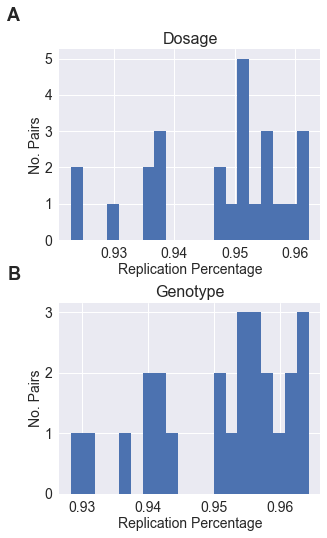

In [18]:
fig, ax = plt.subplots(2,1, figsize = (5,8))
ax1 = ax[0]
ax2 = ax[1]

rr_length_per_pair.RR.hist(bins = 20, ax = ax1)
rr_gt_per_pair.RR.hist(bins = 20, ax = ax2)
ax1.set(xlabel='Replication Percentage', ylabel = 'No. Pairs')
ax2.set(xlabel='Replication Percentage', ylabel = 'No. Pairs')

ax1.set_title('Dosage')
ax2.set_title('Genotype')

fig.text(0.05, 0.95, 'A', weight = 'bold', fontsize = 18)
fig.text(0.05, 0.5, 'B', weight = 'bold', fontsize = 18)


plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.95])



# Distributions of various parameters of the VCF

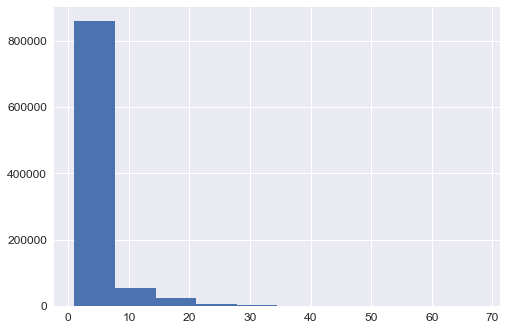

In [120]:
info_dosage.NUM_ALLELES.hist()

In [39]:
info_dosage[info_dosage.NREF > 0].shape

(266841, 31)

In [40]:
info_dosage_plot = info_dosage[info_dosage.NREF > 0]

In [20]:
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10

In [21]:
info_dosage['AVE_DP'] = info_dosage.FRAC_DP

params = ['PERIOD', 'AVE_DP', 'FRAC_DSTUTTER', 'FRAC_DFLANKINDEL','NREF', 'NUM_ALLELES', 'INFRAME_UP', 'INFRAME_DOWN', 'FRAC_MISSING']

/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


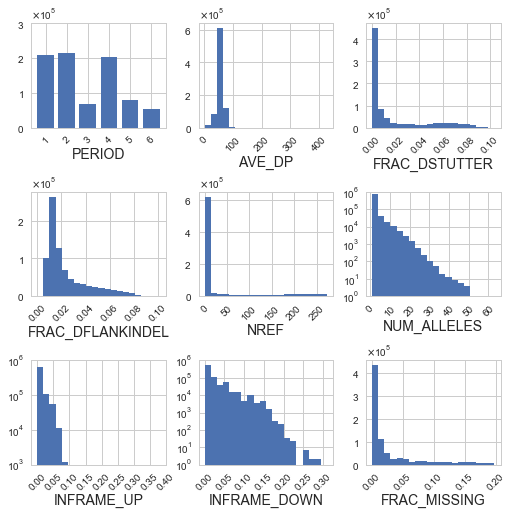

In [22]:
# with plt.rc_context({'axes.autolimit_mode': 'data'}):
with sns.axes_style('whitegrid'):

    fig, ax = plt.subplots(3,3, figsize = (8,8), dpi = 1000)
    ax1 = ax[0]
    ax2 = ax[1]

    tick_original = ticker.MaxNLocator(nbins=15, steps=[1, 2, 5,10])

    axes = fig.get_axes()


    for i, p in enumerate(params):
        hax = axes[i]
        
        if p == 'PERIOD':
            vc = info_dosage[p].value_counts()
            
            hax.bar(vc.index.tolist(), vc.tolist())
            hax.set_ylim(0,300000)
        else:
            hax.hist(info_dosage[p], bins = 20)
            
        

        hax.ticklabel_format(axis ='y', style='sci', scilimits = (0,0), useMathText = True)
        hax.tick_params(axis ='x', labelrotation=45)
        
        hax.xaxis.set_major_locator(ticker.MaxNLocator(nbins= 9,steps = [1, 2, 5,10], min_n_ticks = 4))
        
        
        hax.set_xlabel(p)
        
        
    
    hax = ax[0][1]
    #     hax.set_xl

    hax = ax[2][0]
    hax.set_yscale('log')
    hax.set_yticks([1000, 10000, 100000, 1000000])
    hax.set_ylim(1000, 1000000)
    hax.minorticks_off()
    # hax.yaxis.set_major_locator(ticker.LogLocator(numticks=10))
    #     hax.set_ylim(10000, 1000000)

    hax = ax[2][1]

    hax.set_yscale('log', )
    hax.set_yticks([1,10, 100, 1000, 10000, 100000, 1000000])
    hax.minorticks_off()
    hax.set_ylim(1, 1000000)
    
    
    hax = ax[1][2]
    hax.set_yscale('log')
    hax.set_yticks([1,10, 100, 1000, 10000, 100000, 1000000])
    hax.set_ylim(0, 1000000)
    hax.minorticks_off()
    
    hax = ax[2][2]
#     hax.set_axis_off()

    plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.95])


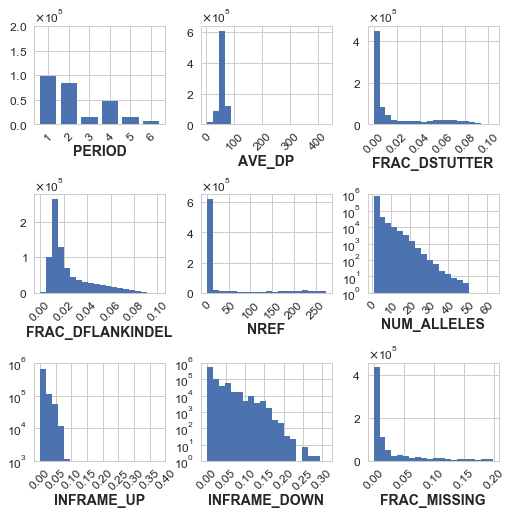

In [42]:
# with plt.rc_context({'axes.autolimit_mode': 'data'}):
with sns.axes_style('whitegrid'):

    fig, ax = plt.subplots(3,3, figsize = (8,8), dpi = 1000)
    ax1 = ax[0]
    ax2 = ax[1]

    tick_original = ticker.MaxNLocator(nbins=15, steps=[1, 2, 5,10])

    axes = fig.get_axes()


    for i, p in enumerate(params):
        hax = axes[i]
        
        if p == 'PERIOD':
            vc = info_dosage_plot[p].value_counts()
            
            hax.bar(vc.index.tolist(), vc.tolist())
            hax.set_ylim(0,200000)
        else:
            hax.hist(info_dosage[p], bins = 20)
            
        

        hax.ticklabel_format(axis ='y', style='sci', scilimits = (0,0), useMathText = True)
        hax.tick_params(axis ='x', labelrotation=45)
        
        hax.xaxis.set_major_locator(ticker.MaxNLocator(nbins= 9,steps = [1, 2, 5,10], min_n_ticks = 4))
        
        
        hax.set_xlabel(p)
        
        
    
    hax = ax[0][1]
    #     hax.set_xl

    hax = ax[2][0]
    hax.set_yscale('log')
    hax.set_yticks([1000, 10000, 100000, 1000000])
    hax.set_ylim(1000, 1000000)
    hax.minorticks_off()
    # hax.yaxis.set_major_locator(ticker.LogLocator(numticks=10))
    #     hax.set_ylim(10000, 1000000)

    hax = ax[2][1]

    hax.set_yscale('log', )
    hax.set_yticks([1,10, 100, 1000, 10000, 100000, 1000000])
    hax.minorticks_off()
    hax.set_ylim(1, 1000000)
    
    
    hax = ax[1][2]
    hax.set_yscale('log')
    hax.set_yticks([1,10, 100, 1000, 10000, 100000, 1000000])
    hax.set_ylim(0, 1000000)
    hax.minorticks_off()
    
    hax = ax[2][2]
#     hax.set_axis_off()

    plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.95])

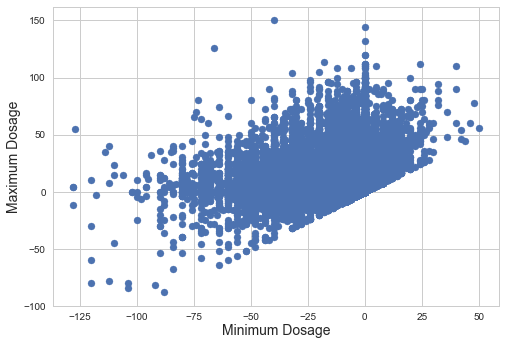

In [23]:
with sns.axes_style('whitegrid'):
    plt.scatter(info_dosage.MIN_DOSAGE, info_dosage.MAX_DOSAGE)
    plt.xlabel('Minimum Dosage')
    plt.ylabel('Maximum Dosage')

# Replication Plots

In [28]:
rr_info_length['AVE_DP'] = rr_info_length.FRAC_DP

In [29]:
thresholds_dp = np.arange(0, 100, 5)

fdf_ave_dp = filtering_df(rr_info_length, info_dosage, 'AVE_DP', 'PERIOD', thresholds_dp)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']


In [30]:
info_dosage['PERC_MISSING'] = info_dosage.FRAC_MISSING
thresholds_pm = np.arange(0, 0.22, 0.02)
fdf_p_missing = filtering_df(rr_info_length, info_dosage, 'PERC_MISSING','PERIOD', thresholds_pm, reverse=True)


In [31]:
thresholds_stutter = np.arange(0, 0.22, 0.02)
fdf_stutter = filtering_df(rr_info_length, info_dosage, 'FRAC_DSTUTTER','PERIOD', thresholds_stutter, reverse=True)

In [33]:
thresholds_iup = np.arange(0, 0.22, 0.02)
fdf_iup = filtering_df(rr_info_length, info_dosage, 'INFRAME_UP', 'PERIOD', thresholds_iup, reverse=True)


In [34]:
thresholds_idown = np.arange(0, 0.5, 0.02)

fdf_idown = filtering_df(rr_info_length, info_dosage, 'INFRAME_DOWN', 'PERIOD', thresholds_idown, reverse=True)


In [35]:
thresholds_flankindel =thresholds_iup = np.arange(0, 0.2, 0.02)

fdf_flankindel = filtering_df(rr_info_length, info_dosage, 'FRAC_DFLANKINDEL', 'PERIOD', thresholds_flankindel, reverse=True)


In [36]:
thresholds_maxp = np.arange(0, 0.5, 0.02)
fdf_maxp = filtering_df(rr_info_length, info_dosage, 'INFRAME_P_Max', 'PERIOD', thresholds_maxp, reverse=True)


In [291]:
rr_info_length['AVE_DP'] = rr_info_length.FRAC_DP

In [294]:
thresholds = np.arange(0, 100, 5)

fdf_ave_dp = filtering_df(rr_info_length, info_dosage, 'AVE_DP', 'PERIOD', thresholds)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']


In [44]:
thresholds_dp = np.arange(0, 100, 5)

fdf_ave_dp = filtering_df(rr_info_length, info_dosage_plot, 'AVE_DP', 'PERIOD', thresholds_dp)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']


info_dosage_plot['PERC_MISSING'] = info_dosage_plot.FRAC_MISSING

thresholds_pm = np.arange(0, 0.22, 0.02)

fdf_p_missing = filtering_df(rr_info_length, info_dosage_plot, 'PERC_MISSING','PERIOD', thresholds_pm, reverse=True)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']

thresholds_stutter = np.arange(0, 0.22, 0.02)

fdf_stutter = filtering_df(rr_info_length, info_dosage_plot, 'FRAC_DSTUTTER','PERIOD', thresholds_stutter, reverse=True)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']

thresholds_iup = np.arange(0, 0.22, 0.02)

fdf_iup = filtering_df(rr_info_length, info_dosage_plot, 'INFRAME_UP', 'PERIOD', thresholds_iup, reverse=True)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']


thresholds_idown = np.arange(0, 0.5, 0.02)

fdf_idown = filtering_df(rr_info_length, info_dosage_plot, 'INFRAME_DOWN', 'PERIOD', thresholds_idown, reverse=True)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']

thresholds_flankindel =thresholds_iup = np.arange(0, 0.2, 0.02)

fdf_flankindel = filtering_df(rr_info_length, info_dosage_plot, 'FRAC_DFLANKINDEL', 'PERIOD', thresholds_flankindel, reverse=True)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']

thresholds_maxp = np.arange(0, 0.5, 0.02)

fdf_maxp = filtering_df(rr_info_length, info_dosage_plot, 'INFRAME_P_Max', 'PERIOD', thresholds_maxp, reverse=True)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']

/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Before Filtering

In [37]:
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['axes.labelweight'] = 'bold'

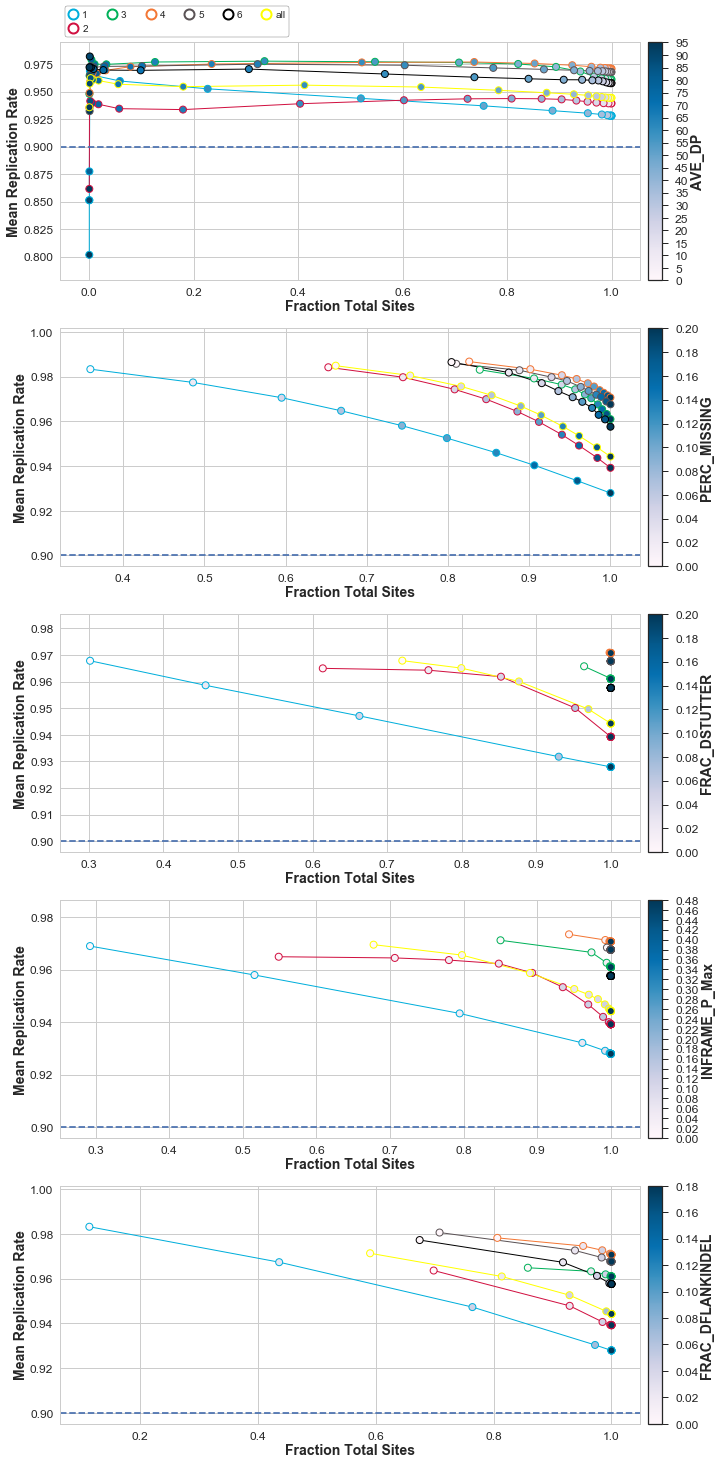

In [38]:
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(5,1, figsize= (10,20))
    
    ax1, divY1, leg1 = plot_discordance_vs_cat(fdf_ave_dp, labels, colors, thresholds_dp, 'PERC_SITES', 'AVE_DP', ax = ax[0])
    
    ax2, divY2, leg2 = plot_discordance_vs_cat(fdf_p_missing, labels, colors, thresholds_pm, 'PERC_SITES', 'PERC_MISSING', ax = ax[1])
    
    ax3, divY3, leg3 = plot_discordance_vs_cat(fdf_stutter, labels, colors, thresholds_stutter, 'PERC_SITES', 'FRAC_DSTUTTER', ax = ax[2])
    
    
    ax4, divY4, leg4 = plot_discordance_vs_cat(fdf_maxp, labels, colors, thresholds_maxp, 'PERC_SITES', 'INFRAME_P_Max', ax = ax[3])
    
    ax5, divY5, leg5 = plot_discordance_vs_cat(fdf_flankindel, labels, colors, thresholds_flankindel,'PERC_SITES',
                                               'FRAC_DFLANKINDEL', ax = ax[4])
    
    
#     ax5, divY4, leg5 = plot_discordance_vs_cat(fdf_idown, labels, colors, thresholds_idown, 'PERC_SITES', 'INFRAME_DOWN', ax = ax[4])
    
    
#     leg1.set_visible(False)
    leg2.set_visible(False)
    leg3.set_visible(False)
    leg4.set_visible(False)
    leg5.set_visible(False)
    
    plt.tight_layout()

# Filtered

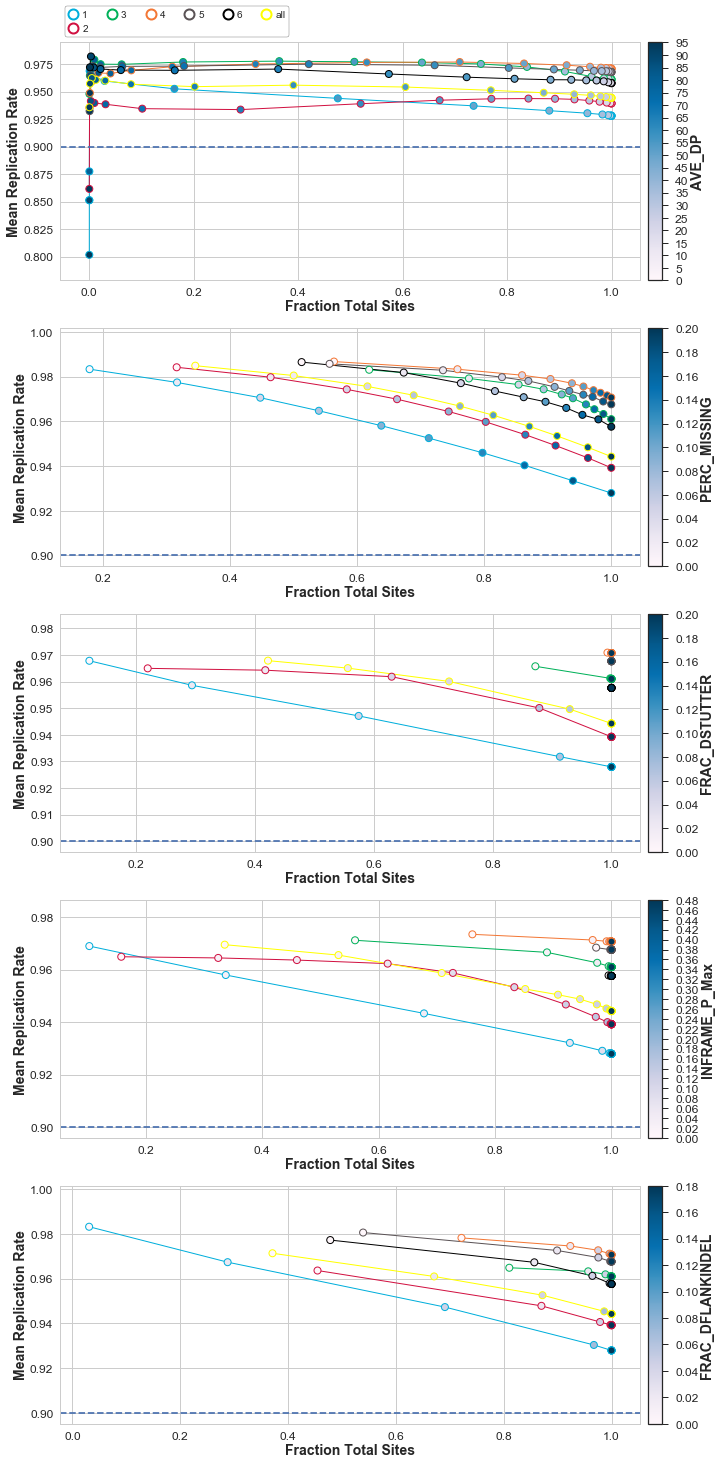

In [45]:
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(5,1, figsize= (10,20))
    
    ax1, divY1, leg1 = plot_discordance_vs_cat(fdf_ave_dp, labels, colors, thresholds_dp, 'PERC_SITES', 'AVE_DP', ax = ax[0])
    
    ax2, divY2, leg2 = plot_discordance_vs_cat(fdf_p_missing, labels, colors, thresholds_pm, 'PERC_SITES', 'PERC_MISSING', ax = ax[1])
    
    ax3, divY3, leg3 = plot_discordance_vs_cat(fdf_stutter, labels, colors, thresholds_stutter, 'PERC_SITES', 'FRAC_DSTUTTER', ax = ax[2])
    
    
    ax4, divY4, leg4 = plot_discordance_vs_cat(fdf_maxp, labels, colors, thresholds_maxp, 'PERC_SITES', 'INFRAME_P_Max', ax = ax[3])
    
    ax5, divY5, leg5 = plot_discordance_vs_cat(fdf_flankindel, labels, colors, thresholds_flankindel,'PERC_SITES',
                                               'FRAC_DFLANKINDEL', ax = ax[4])
    
    
#     ax5, divY4, leg5 = plot_discordance_vs_cat(fdf_idown, labels, colors, thresholds_idown, 'PERC_SITES', 'INFRAME_DOWN', ax = ax[4])
    
    
#     leg1.set_visible(False)
    leg2.set_visible(False)
    leg3.set_visible(False)
    leg4.set_visible(False)
    leg5.set_visible(False)
    
    plt.tight_layout()

In [46]:
info_dosage_plot.shape

(266841, 31)

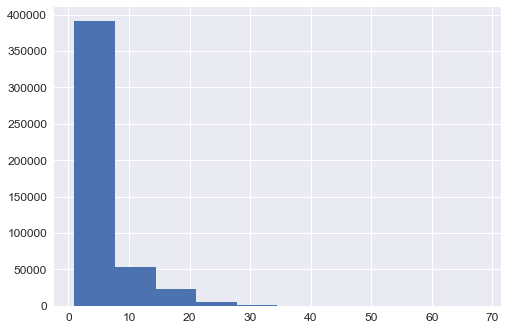

In [168]:
info_dosage[info_dosage.NREF > 0].NUM_ALLELES.hist()

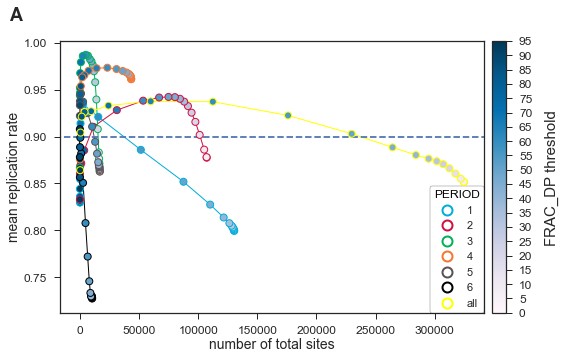

In [225]:
ax = plot_discordance_vs_cat(fdf, labels, colors, thresholds, 'num_sites', 'FRAC_DP', 'A')
# ax.set_xlim(-2000,150000)

In [251]:
f, d = fdf.pipe(add_percentage_of_sites, 'PERIOD', 'num_sites')

In [221]:
tdf = info_dosage.groupby('PERIOD').get_group(2)

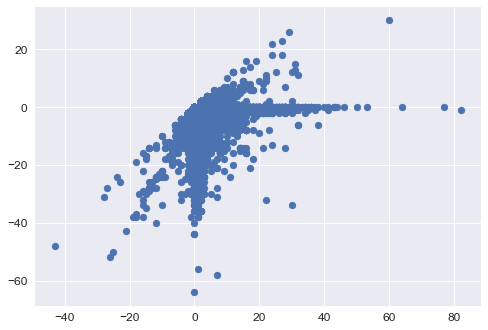

In [220]:
plt.scatter(tdf.MAX_DOSAGE, tdf.MIN_DOSAGE)

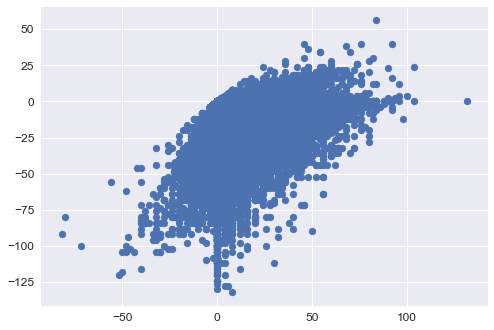

In [222]:
plt.scatter(tdf.MAX_DOSAGE, tdf.MIN_DOSAGE)

In [283]:
info_dosage.MAX_DOSAGE.describe()

count    944505.000000
mean          2.534919
std           6.966426
min         -82.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         132.000000
Name: MAX_DOSAGE, dtype: float64

In [218]:
info_dosage.head()

,ID,NREF,REF,NMissing,NNREF_UUIDs,NNREF_AF,ALLELES_DIST,FRAC_MISSING,MIN_Q,MAX_FLANKINDEL,MAX_DSTUTTER,MIN_AB,MIN_FS,MAX_DOSAGE,MIN_DOSAGE,DP,DSTUTTER,DFLANKINDEL,PERIOD,NFILT,INFRAME_UP,INFRAME_DOWN,FRAC_DP,FRAC_DSTUTTER,FRAC_DFLANKINDEL,NUM_ALLELES,ALLELES,ALLELES_DIST_MOD,INFRAME_P_Max
0,Human_STR_76,0,235,38,NaN,0.0000,"0:235,./.:38",0.139,1.00,1.0,2.0,0.00,0.00,0.0,0.0,892,10,2,1,23,0.01,0.00,3.7957,0.0112,0.0022,1,0,0:235,0.01
1,Human_STR_89,0,256,17,NaN,0.0000,"0:256,./.:17",0.062,1.00,2.0,1.0,0.00,0.00,0.0,0.0,2946,9,46,4,4,0.00,0.00,11.5078,0.0031,0.0156,1,0,0:256,0.00
2,Human_STR_95,0,247,26,NaN,0.0000,"0:247,./.:26",0.095,0.60,1.0,1.0,-0.11,0.00,0.0,0.0,2052,1,15,2,3,0.00,0.00,8.3077,0.0005,0.0073,1,0,0:247,0.00
3,Human_STR_96,30,193,50,"dd709123-35fa-44e5-b8b2-10d8bcff9294,c08cc10c-...",0.1554,"./.:50,1:14,0:193,2:1,-1:10,-2:5",0.183,0.05,2.0,5.0,-0.84,-1.18,2.0,-2.0,1738,148,64,1,43,0.05,0.09,7.7937,0.0852,0.0368,5,"1,0,2,-1,-2","1:14,0:193,2:1,-1:10,-2:5",0.09
4,Human_STR_104,0,236,37,NaN,0.0000,"0:236,./.:37",0.136,1.00,1.0,0.0,0.00,0.00,0.0,0.0,874,0,1,2,3,0.00,0.00,3.7034,0.0000,0.0011,1,0,0:236,0.00


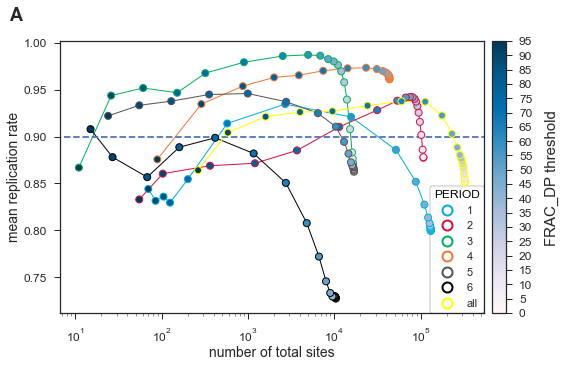

In [149]:
ax = plot_discordance_vs_cat(fdf, labels, colors, thresholds, 'num_sites', 'FRAC_DP', 'A')
ax.set_xscale('log')
# ax.tick_params(which = 'both', labelsize= 20, )

In [308]:
info_dosage['PERC_MISSING'] = info_dosage.FRAC_MISSING

In [311]:
thresholds = np.arange(0, 0.22, 0.02)

fdf_p_missing = filtering_df(rr_info_length, info_dosage, 'PERC_MISSING','PERIOD', thresholds, reverse=True)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']


In [ ]:
ax = plot_discordance_vs_cat(fdf, labels, colors, thresholds, 'num_sites', 'PERC_MISSING', 'B')

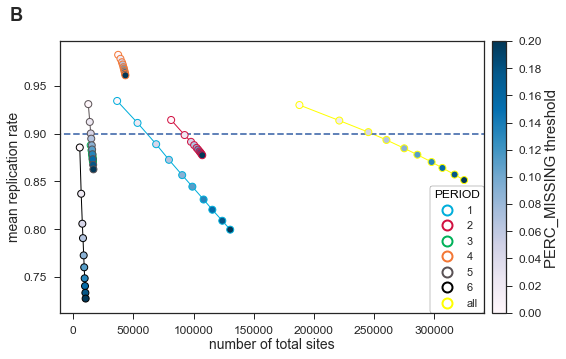

In [151]:
ax = plot_discordance_vs_cat(fdf, labels, colors, thresholds, 'num_sites', 'PERC_MISSING', 'B')

In [300]:
thresholds = np.arange(0, 0.22, 0.02)

fdf_stutter = filtering_df(rr_info_length, info_dosage, 'FRAC_DSTUTTER','PERIOD', thresholds, reverse=True)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']


In [305]:
fdf_stutter.head()

,level_0,PERC_SITES,PERIOD,index,mean_replication_rate,num_sites,num_sites_all,thresh
0,0,1.000000,1,NaN,NaN,0,270331,0.00
1,1,0.764984,1,NaN,0.956441,10083,206799,0.02
2,2,0.644162,1,NaN,0.929139,25175,174137,0.04
3,3,0.495726,1,NaN,0.907445,47980,134010,0.06
4,4,0.287958,1,NaN,0.871987,77544,77844,0.08


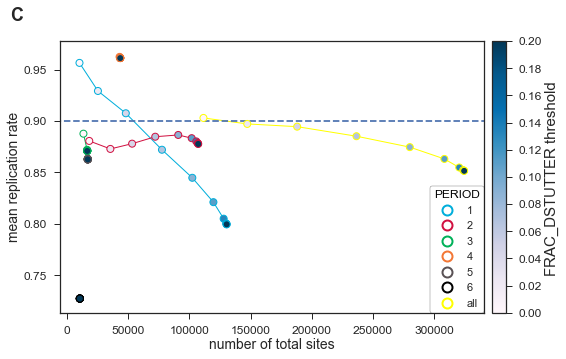

In [304]:
ax = plot_discordance_vs_cat(fdf_stutter, labels, colors, thresholds, 'num_sites', 'FRAC_DSTUTTER', 'C')

In [154]:
thresholds = np.arange(0, 0.22, 0.02)

fdf = filtering_df(rr_info_length, info_dosage, 'INFRAME_UP', thresholds, reverse=True)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']


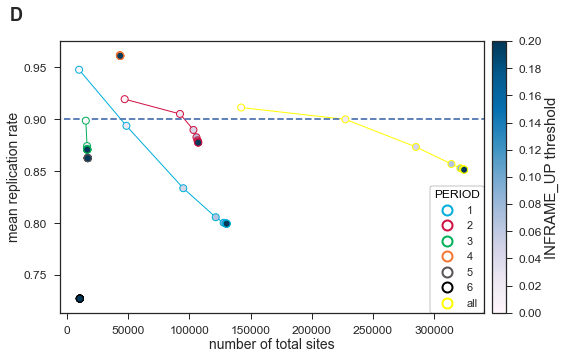

In [156]:
ax = plot_discordance_vs_cat(fdf, labels, colors, thresholds, 'num_sites', 'INFRAME_UP', 'D')

In [195]:
thresholds = np.arange(0, 0.5, 0.02)

fdf_down = filtering_df(rr_info_length, info_dosage, 'INFRAME_DOWN', thresholds, reverse=True)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']

In [198]:
info_dosage.shape

(944505, 29)

In [199]:
Human_STR_38

ref = "ATCTCAAAAAAAAAAAAAAAA"   
ALT = "ATCTAAAAAAAAAAAAAAAAA,AACTCAAAAAAAAAAAAAAAAA,ATCTAAAAAAAAAAAAAAAAAA,ATCTCAAAAAAAAAAAAAAAAA".split(',')

In [200]:
ref2 = 'ATCTCAAAAAAAAAAAAAAAA'
ALT2 = 'ATCTAAAAAAAAAAAAAAAAA,AACTCAAAAAAAAAAAAAAAAA,ATCTAAAAAAAAAAAAAAAAAA,ATCTCAAAAAAAAAAAAAAAAA'.split(',')

In [201]:
ALT == ALT2

True

In [202]:
ref3 = 'ATCTCAAAAAAAAAAAAAAAA'
ALT2 = 'ATCTCAAAAAAAAAAAAAA,ATCTAAAAAAAAAAAAAAAA,ATCTCAAAAAAAAAAAAAAA,AACTCAAAAAAAAAAAAAAAA,ATCTAAAAAAAAAAAAAAAAA,ATCTCAAAAAAAAAAAAAAAAA,ATCTCAAAAAAAAAAAAAAAAAA'

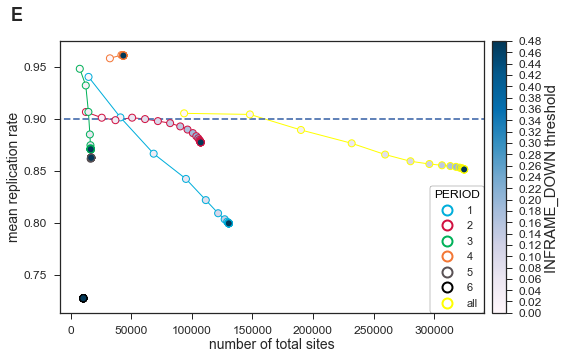

In [197]:
ax = plot_discordance_vs_cat(fdf_down, labels, colors, thresholds, 'num_sites', 'INFRAME_DOWN', 'E')

In [211]:
thresholds = np.arange(0, 0.5, 0.02)

fdf = filtering_df(rr_info_length, info_dosage, 'INFRAME_P_Max', thresholds, reverse=True)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']

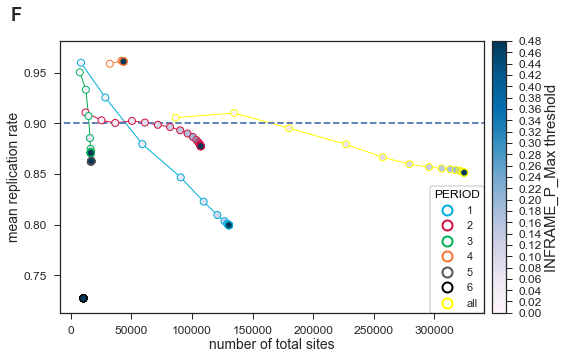

In [193]:
ax = plot_discordance_vs_cat(fdf, labels, colors, thresholds, 'num_sites', 'INFRAME_P_Max', 'F')